<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/Prueba2_Random_Forest_datos_combinados2019_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeras filas del dataset combinado:
    AÃ±o    Mes Departamento                Ciclo    Zona       Contexto  \
0  2019  Marzo     Paysandu  Primaria 2do. Ciclo  Urbana  Quintil 1 y 2   
1  2019  Marzo    Lavalleja  Primaria 1er. Ciclo  Urbana      Quintil 3   
2  2019  Marzo      Florida  Primaria 1er. Ciclo   Rural  Quintil 1 y 2   
3  2019  Marzo    Maldonado  Primaria 1er. Ciclo   Rural      Quintil 3   
4  2019  Marzo     San Jose  Primaria 2do. Ciclo  Urbana      Quintil 3   

   UsuariosCREA  UsuariosMAT  UsuariosBiblioteca  
0           797          364                  51  
1             0            1                   0  
2             0            0                   0  
3             0            0                   0  
4            81           23                  12   

Meses únicos tras limpieza: ['Abril', 'Agosto', 'Diciembre', 'Julio', 'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'] 

Distribución de niveles de interacción:
 NivelInteraccion
Baja    

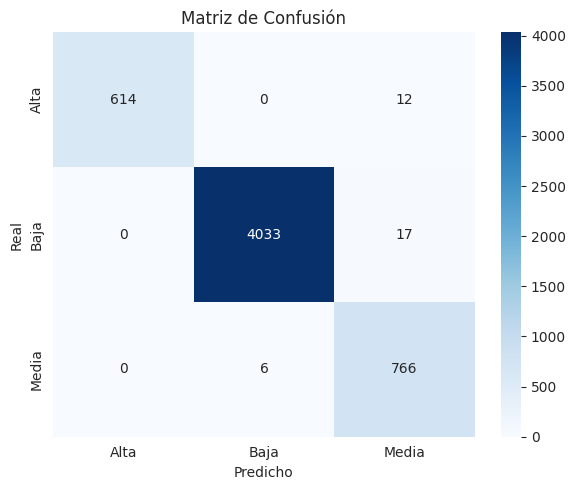

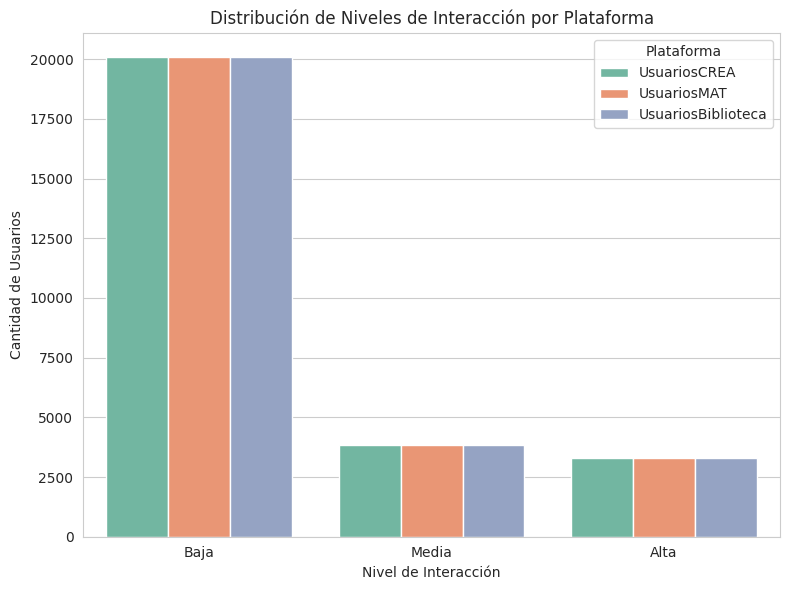

<Figure size 1000x600 with 0 Axes>

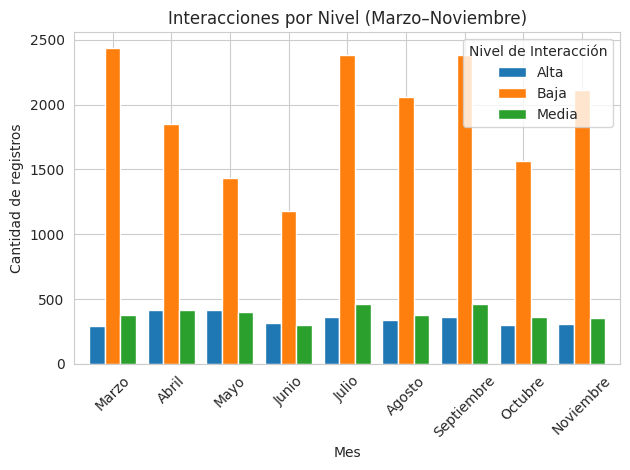

In [ ]:
# PASO 0: Instalación de librerías (solo si falta algo)
!pip install -q scikit-learn pandas matplotlib seaborn

# PASO 1: Importación de librerías
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

sns.set_style('whitegrid')

# PASO 2: Carga y combinación de CSVs
data_path = '/content/'
csv_files = ['2019 primaria.csv', '2021 primaria.csv', '2022 primaria.csv',
             '2023 primaria.csv', '2024 primaria.csv']
dfs = [pd.read_csv(os.path.join(data_path, f), encoding='latin-1') for f in csv_files]
full_df = pd.concat(dfs, ignore_index=True)
print("Primeras filas del dataset combinado:\n", full_df.head(), "\n")

# PASO 3: Limpieza de nombres de columnas y estandarización de meses
full_df.columns = ['Anio', 'Mes', 'Departamento', 'Ciclo', 'Zona', 'Contexto',
                   'UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']
full_df['Mes'] = (full_df['Mes']
                  .str.strip()
                  .str.capitalize()
                  .replace({'Setiembre': 'Septiembre'}))
print("Meses únicos tras limpieza:", sorted(full_df['Mes'].unique()), "\n")

# PASO 4: Crear 'InteraccionTotal' y 'NivelInteraccion'
full_df['InteraccionTotal'] = (full_df['UsuariosCREA']
                               + full_df['UsuariosMAT']
                               + full_df['UsuariosBiblioteca'])
def clasificar_interaccion(v):
    if v < 100: return 'Baja'
    elif v < 500: return 'Media'
    else: return 'Alta'
full_df['NivelInteraccion'] = full_df['InteraccionTotal'].apply(clasificar_interaccion)
print("Distribución de niveles de interacción:\n",
      full_df['NivelInteraccion'].value_counts(), "\n")

# PASO 5: Preparar datos para el modelo
X = full_df[['Anio', 'Mes', 'UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']].copy()
y = full_df['NivelInteraccion']
le_mes = LabelEncoder()
X['Mes'] = le_mes.fit_transform(X['Mes'])

# PASO 6: Entrenamiento y evaluación con Random Forest
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

modelo = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# PASO 7: Gráfica de torta por plataforma
full_df_melted = full_df.melt(
    id_vars=['NivelInteraccion'],
    value_vars=['UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca'],
    var_name='Plataforma',
    value_name='Interacciones'
)
plt.figure(figsize=(8,6))
sns.countplot(data=full_df_melted,
              x='NivelInteraccion',
              hue='Plataforma',
              order=['Baja','Media','Alta'],
              palette='Set2')
plt.title('Distribución de Niveles de Interacción por Plataforma')
plt.xlabel('Nivel de Interacción')
plt.ylabel('Cantidad de Usuarios')
plt.legend(title='Plataforma')
plt.tight_layout()
plt.show()

# PASO 8: Gráfica de barras agrupadas (Marzo–Noviembre)
meses_excluidos = ['Enero', 'Febrero', 'Diciembre']
df_filtrado = full_df[~full_df['Mes'].isin(meses_excluidos)]
pivot = (df_filtrado
         .groupby(['Mes','NivelInteraccion'])
         .size()
         .unstack(fill_value=0)
         .reindex(['Marzo','Abril','Mayo','Junio','Julio',
                   'Agosto','Septiembre','Octubre','Noviembre']))
plt.figure(figsize=(10,6))
pivot.plot(kind='bar', stacked=False, width=0.8)
plt.title('Interacciones por Nivel (Marzo–Noviembre)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de registros')
plt.legend(title='Nivel de Interacción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def clasificar_interaccion(v):
    if v < 100: return 'Baja'
    elif v < 500: return 'Media'
    else: return 'Alta'

# creamos tres columnas nuevas, una por plataforma
full_df['NivelCREA']        = full_df['UsuariosCREA'].apply(clasificar_interaccion)
full_df['NivelMAT']         = full_df['UsuariosMAT'].apply(clasificar_interaccion)
full_df['NivelBiblioteca']  = full_df['UsuariosBiblioteca'].apply(clasificar_interaccion)


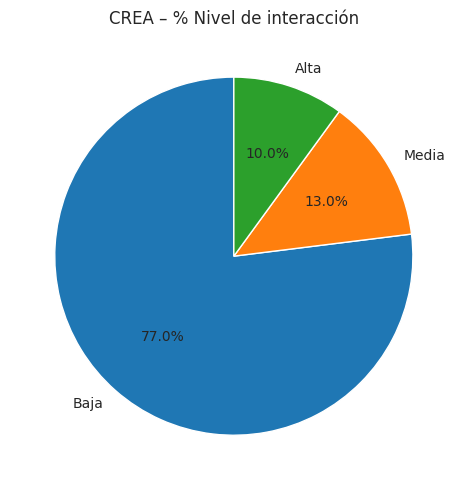

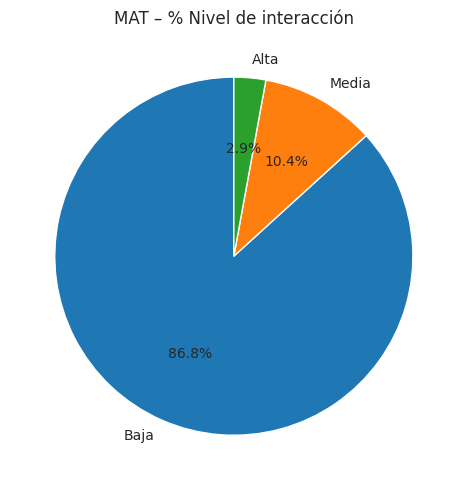

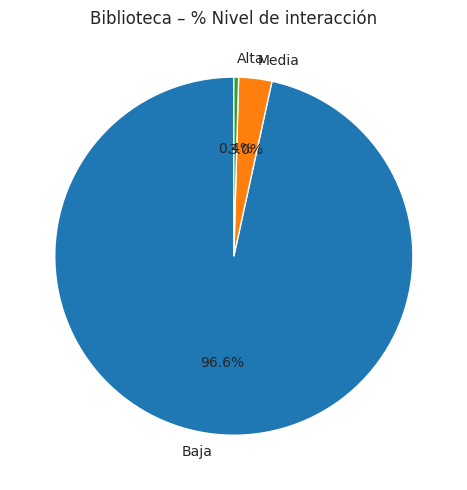

In [ ]:
for plataforma, columna in [
    ('CREA',       'NivelCREA'),
    ('MAT',        'NivelMAT'),
    ('Biblioteca','NivelBiblioteca')
]:
    conteos = (full_df[columna]
               .value_counts(normalize=True)
               .reindex(['Baja','Media','Alta']))

    plt.figure(figsize=(5,5))
    plt.pie(
        conteos,
        labels=conteos.index,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor':'white'}
    )
    plt.title(f'{plataforma} – % Nivel de interacción')
    plt.tight_layout()
    plt.show()



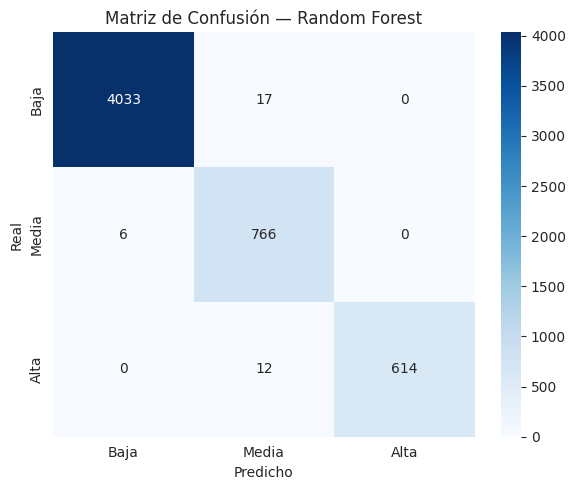

In [ ]:
# ========================================
# PASO 10: Matriz de Confusión
# ========================================
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Volvemos a predecir (si no lo tienes en y_pred)
y_pred = modelo.predict(X_test)

# 2. Calculamos la matriz (asegúrate de usar el mismo orden de clases)
clases = ['Baja','Media','Alta']
cm = confusion_matrix(y_test, y_pred, labels=clases)

# 3. Dibujamos el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clases, yticklabels=clases)
plt.title('Matriz de Confusión — Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


In [ ]:
# PASO 11: Crear tabla con Precision, Accuracy y Recall
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculamos las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, labels=clases)
recall = recall_score(y_test, y_pred, average=None, labels=clases)

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame({
    'Clase': clases,
    'Precisión': precision,
    'Recall': recall
})

# Añadir precisión global (accuracy)
metrics_df.loc['Promedio', 'Precisión'] = np.mean(precision)
metrics_df.loc['Promedio', 'Recall'] = np.mean(recall)
metrics_df.loc['Promedio', 'Clase'] = 'Promedio'
metrics_df.loc['Total', 'Precisión'] = accuracy
metrics_df.loc['Total', 'Recall'] = accuracy
metrics_df.loc['Total', 'Clase'] = 'Total'

# Mostrar la tabla
print(metrics_df)


             Clase  Precisión    Recall
0             Baja   0.998514  0.995802
1            Media   0.963522  0.992228
2             Alta   1.000000  0.980831
Promedio  Promedio   0.987345  0.989620
Total        Total   0.993576  0.993576


In [ ]:
# Guardar el DataFrame combinado en un archivo CSV
output_path = '/content/dataset_combinado.csv'
full_df.to_csv(output_path, index=False)

# Mostrar la ruta para descarga
print(f"El archivo CSV ha sido guardado en: {output_path}")


El archivo CSV ha sido guardado en: /content/dataset_combinado.csv
